In [ ]:
pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
pip install matplotlib


In [ ]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import warnings
warnings.simplefilter("ignore")

MAX_GRAD_NORM = 1.2
EPSILON = 3
DELTA = 1e-5
EPOCHS = 10

LR = 1e-2
BATCH_SIZE = 256
MAX_PHYSICAL_BATCH_SIZE = 128

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
])


DATA_ROOT = '../cifar10'

train_dataset = CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


In [ ]:
from opacus.validators import ModuleValidator

from torchvision import models

model = models.resnet18(num_classes=10)

errors = ModuleValidator.validate(model, strict=False)
errors[-5:]

[opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the same sample x will get normalized to a different value depending on who else is on its batch. Privacy-wise, this means that we would have to put a privacy mechanism there too. While it can in principle be done, there are now multiple normalization layers that do not have this issue: LayerNorm, InstanceNorm and their generalization GroupNorm are all privacy-safe since they don't have this property.We offer utilities to automatically replace BatchNorms to GroupNorms and we will release pretrained models to help transition, such as GN-ResNet ie a ResNet using GroupNorm, pretrained on ImageNet"),
 opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normal

In [ ]:
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

[]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from opacus import PrivacyEngine
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)


def accuracy(preds, labels):
    return (preds == labels).mean()

privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")


Using sigma=1.2109375 and C=1.2


Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 9.851007 Acc@1: 11.343807 (ε = 0.20, δ = 1e-05)
	Train Epoch: 1 	Loss: 6.238335 Acc@1: 15.033219 (ε = 0.27, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.422794 Acc@1: 23.157156 (ε = 0.34, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.428551 Acc@1: 23.868476 (ε = 0.38, δ = 1e-05)
	Train Epoch: 3 	Loss: 2.418537 Acc@1: 26.319158 (ε = 0.43, δ = 1e-05)
	Train Epoch: 3 	Loss: 2.408240 Acc@1: 26.878885 (ε = 0.47, δ = 1e-05)
	Train Epoch: 4 	Loss: 2.427223 Acc@1: 27.974497 (ε = 0.51, δ = 1e-05)
	Train Epoch: 4 	Loss: 2.422939 Acc@1: 28.865525 (ε = 0.54, δ = 1e-05)
	Train Epoch: 5 	Loss: 2.449262 Acc@1: 29.211656 (ε = 0.58, δ = 1e-05)
	Train Epoch: 5 	Loss: 2.399203 Acc@1: 29.724167 (ε = 0.61, δ = 1e-05)
	Train Epoch: 6 	Loss: 2.396294 Acc@1: 29.523279 (ε = 0.64, δ = 1e-05)
	Train Epoch: 6 	Loss: 2.425883 Acc@1: 29.762975 (ε = 0.67, δ = 1e-05)
	Train Epoch: 7 	Loss: 2.402687 Acc@1: 30.168198 (ε = 0.70, δ = 1e-05)
	Train Epoch: 7 	Loss: 2.359707 Acc@1: 30.934940 (ε = 0.72, δ = 1e-05)
	Train

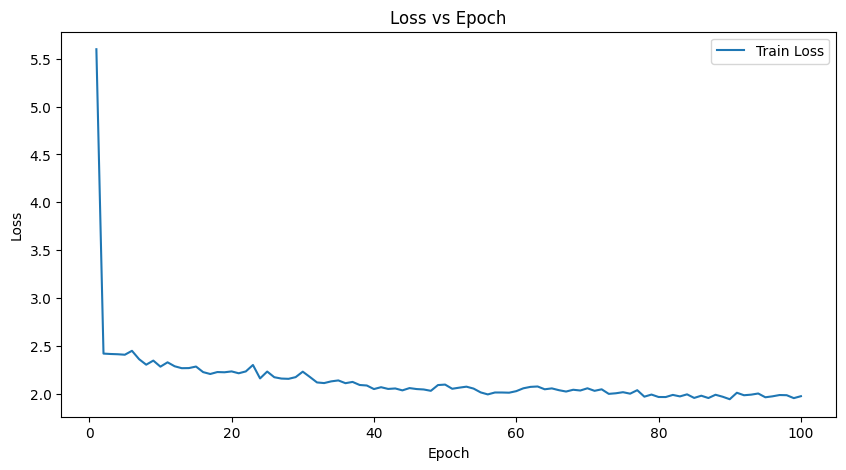

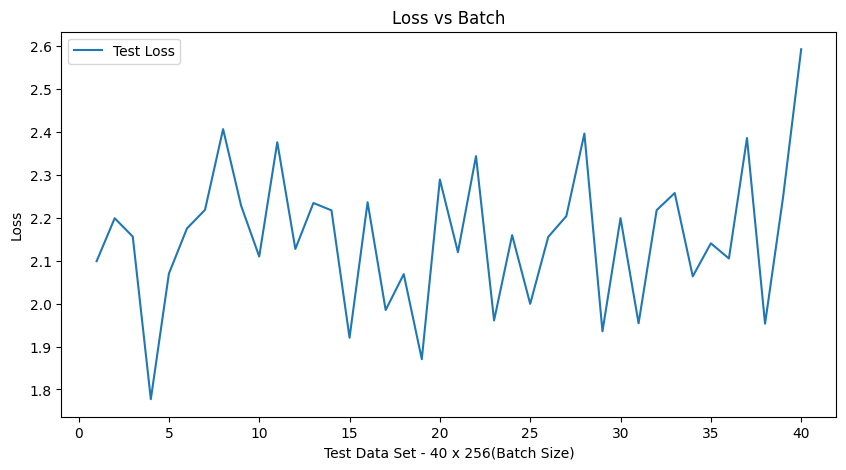

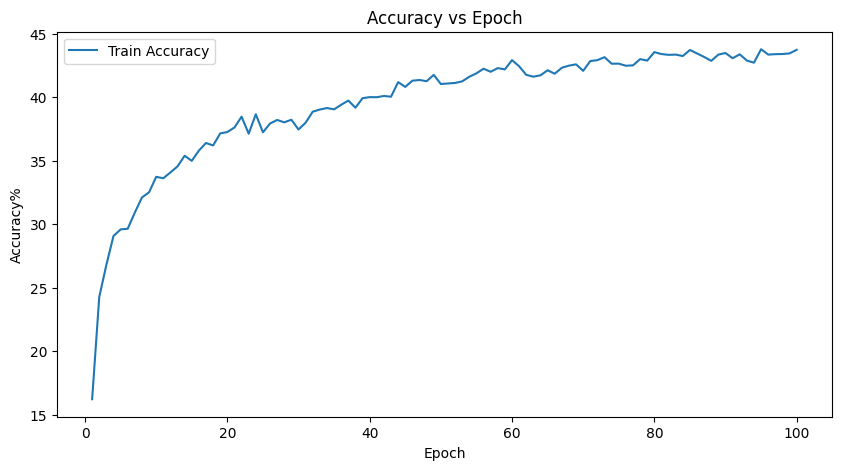

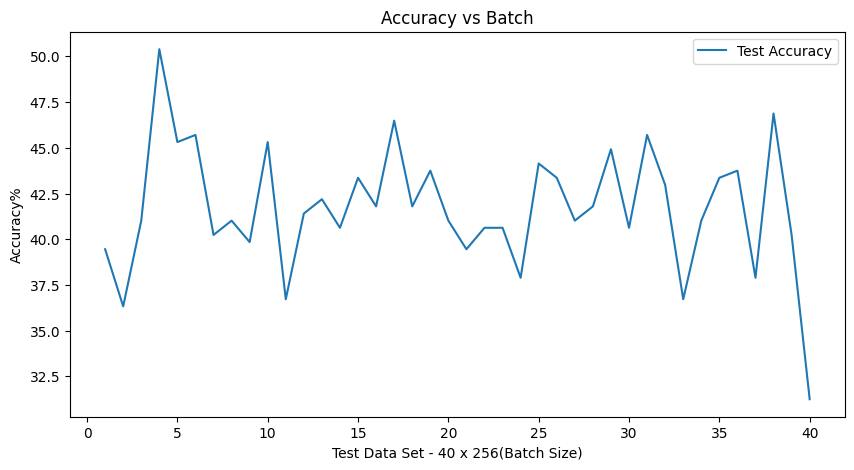

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from opacus.utils.batch_memory_manager import BatchMemoryManager

def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    train_loss=[]
    train_acc=[]
    top1_acc = []

    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)


            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()


            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                #train_loss.append("{:.4f}".format(np.mean(losses)))
                #train_acc.append("{:.4f}".format(np.mean(top1_acc)))
                print(

                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    #f"Loss: {train_loss} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    #f"Acc@1: {train_acc} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )

    #print(np.mean(losses), np.mean(top1_acc))
    return np.mean(losses), np.mean(top1_acc)*100


def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss=[]
    top1_avg=0
    top1_acc = []
    test_acc=[]
    test_losses = []
    top1_acc = []
    round2=0
    round1=0

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)
            round1=round(loss.item(), 4)
            round2=round(acc*100, 4)
            test_losses.append(round1)
            top1_acc.append(round2)
            #top1_acc=float(top1_acc)
            #test_losses=float(test_losses)
            #i+=1
            #top1_acc = [float(acc) for acc in top1_acc]
            #test_losses = [float(loss) for loss in test_losses]
            #print(top1_acc)
            #print(test_losses)
            #test_acc=top1_acc
    top1_avg = np.mean(top1_acc)
    #print(type(tsl))
    #print(type(tsa))
    print(
        f"\tTest set:"
        f"Loss: {np.mean(test_losses):.6f} "
        f"Acc: {top1_avg :.6f} "
    )



    #for i in EPOCHS:
    #print(list(map(float, top1_acc)))
    #print(list(map(float, test_losses)))
    print(len(test_losses))
    print(top1_acc)
    print(test_losses)

    return test_losses, top1_acc#, np.std(test_losses), np.std(top1_acc)*100, np.var(test_losses), np.var(top1_acc)*100

def accuracy(preds, labels):
    return (preds == labels).sum() / len(labels)

from tqdm.notebook import tqdm

trl=[]
tra=[]

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    trl, tra = train(model, train_loader, optimizer, epoch + 1, device)
    #print(trl, tra)
    trl1.insert(epoch, trl)
    tra1.insert(epoch, tra)

    #tra1+=tra
    #print(trl1, tra1)

tsl=[]
tsa=[]

#print(type(tsl))
#print(type(tsa))
#for epoch in range(1, EPOCHS + 1):
#tsl, tsa, tsls, tsas, tslv, tsav = test(model, test_loader, criterion)
tsl, tsa = test(model, test_loader, device)
#print(tsa, tsl)
#print(len(tsl1))
print(f"Standard Deviation Train loss : {np.std(tsa):.4f}")
print(f"Standard Deviation Test loss : {np.std(tsl):.4f}")
print(f"Variance in Train Accuracy : {np.var(tsa):.4f}")
print(f"Variance in Test Accuracy : {np.var(tsl):.4f}")


#print(len(tsa1))
#tsl1=tsl
#tsa1=tsa
'''tsls1.insert(epoch, tsls)
tsas1.insert(epoch, tsas)
tslv1.insert(epoch, tslv)
tsav1.insert(epoch, tsav)'''
#print(type(tsl))
#print(type(tsa))
#print(tsl1)
#print("ffffffffffffffffff")
#print(tsa1)
#print(tsav1)
#print(tsas1)
#print(np.mean(trl1))

plt.figure(figsize=(10, 5))
#max=max(trl1, tsl1)

#plt.subplot(1, 2, 1)
epochs = range(1, EPOCHS+1)

plt.plot(epochs, trl1, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.figure(figsize=(10, 5))
#max=max(trl1, tsl1)

epochs_range = range(1,len(tsl)+1)
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, tsl, label='Test Loss')
plt.xlabel('Test Data Set - 40 x 256(Batch Size)')
plt.ylabel('Loss')
plt.title('Loss vs Batch')
plt.legend()

plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 2)
epochs = range(1, EPOCHS+1)
plt.plot(epochs, tra1, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy%')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 2)
epochs_range = range(1, len(tsa)+1)
plt.plot(epochs_range, tsa, label='Test Accuracy')
plt.xlabel('Test Data Set - 40 x 256(Batch Size)')
plt.ylabel('Accuracy%')
plt.title('Accuracy vs Batch')
plt.legend()

